# Deep Learning Volatility - Interactive Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BianchiGiacomo/deepLearningVolatility/blob/main/examples/GoogleColab/dlvol_demo_colab.ipynb)

An end-to-end framework for neural volatility surface approximation, achieving significant computational speedup compared to traditional Monte Carlo methods.

## Overview

This notebook demonstrates:
- Loading pre-trained neural network pricers
- Generating implied volatility smiles in real-time
- Comparing performance with Monte Carlo methods
- Interactive parameter exploration for rough volatility models

## Setup & Installation

In [2]:
# Clone repository (uncomment for Colab)
!git clone https://github.com/BianchiGiacomo/deepLearningVolatility.git
%cd deepLearningVolatility

Cloning into 'deepLearningVolatility'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (306/306), done.
remote: Total 408 (delta 198), reused 306 (delta 96), pack-reused 0 (from 0)
Receiving objects: 100% (408/408), 3.49 MiB | 8.16 MiB/s, done.
Resolving deltas: 100% (198/198), done.
/content/deepLearningVolatility


In [6]:
import sys
from pathlib import Path
import torch
torch.set_default_dtype(torch.float32)  # Ensure float32 as global default
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import time
import warnings
warnings.filterwarnings('ignore')

# Setup paths
ROOT_DIR = Path('.').resolve()
sys.path.append(str(ROOT_DIR))

from deepLearningVolatility.nn.pricer.pricer import PointwiseNetworkPricer
from deepLearningVolatility.stochastic.stochastic_interface import ProcessFactory
from deepLearningVolatility.stochastic.wrappers import rough_bergomi_wrapper

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Setup complete. Using device: {DEVICE}")

Setup complete. Using device: cpu


## Download Pre-trained Weights

We'll fetch the pre-trained model weights for the Rough Bergomi process from the repository.

In [7]:
# Auto-fetch required files from GitHub
import pathlib
import requests

BRANCH = "main"
BASE_RAW = f"https://raw.githubusercontent.com/BianchiGiacomo/deepLearningVolatility/{BRANCH}/models/Pointwise/RoughBergomi/"
BASE_MEDIA = f"https://media.githubusercontent.com/media/BianchiGiacomo/deepLearningVolatility/{BRANCH}/models/Pointwise/RoughBergomi/"

REQUIRED_FILES = [
    "pointwise_random_grids_latest.pt",
    "pointwise_random_grids_latest_config.json",
]

LOCAL_DIR = pathlib.Path("models/Pointwise/RoughBergomi")
LOCAL_DIR.mkdir(parents=True, exist_ok=True)

def download_file(url, dest):
    """Download file from URL to destination"""
    try:
        response = requests.get(url, timeout=60, allow_redirects=True)
        if response.status_code == 200 and response.content:
            dest.write_bytes(response.content)
            return True
    except:
        pass
    return False

def fetch_model_file(filename):
    """Fetch model file from GitHub (handles both regular and LFS files)"""
    dest = LOCAL_DIR / filename
    if dest.exists() and dest.stat().st_size > 0:
        return dest

    # Try raw URL first, then media URL for LFS
    if download_file(BASE_RAW + filename, dest) or download_file(BASE_MEDIA + filename, dest):
        return dest
    raise FileNotFoundError(f"Unable to fetch {filename}")

for filename in REQUIRED_FILES:
    path = fetch_model_file(filename)
    print(f"Downloaded: {path}")

Downloaded: models/Pointwise/RoughBergomi/pointwise_random_grids_latest.pt
Downloaded: models/Pointwise/RoughBergomi/pointwise_random_grids_latest_config.json


## Load Neural Network Pricer

The Rough Bergomi model is particularly challenging for traditional pricing methods due to its non-Markovian nature. Our neural network learns to approximate the pricing function efficiently.

In [8]:
import json

def load_trained_model(checkpoint_path, config_path, device='cpu'):
    """Load pre-trained PointwiseNetworkPricer"""

    # Initialize Rough Bergomi process
    process = ProcessFactory.create('rough_bergomi')

    # Default architecture
    hidden_layers = [30, 30, 30, 30]
    activation = 'ELU'

    # Load configuration if available
    try:
        with open(config_path, 'r') as f:
            config = json.load(f)
        if 'training_config' in config:
            hidden_layers = config['training_config'].get('hidden_layers', hidden_layers)
            activation = config['training_config'].get('activation', activation)
    except Exception as e:
        print(f"Using default configuration: {e}")

    # Create pricer
    pricer = PointwiseNetworkPricer(
        process=process,
        hidden_layers=hidden_layers,
        activation=activation,
        device=device
    )

    # Ensure float32 dtype
    pricer.net = pricer.net.float()

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model_state = checkpoint.get('model_state_dict', checkpoint)
    pricer.net.load_state_dict(model_state)

    # Load normalization statistics
    if 'normalization_stats' in checkpoint:
        stats = checkpoint['normalization_stats']
        pricer.set_normalization_stats(
            stats['theta_mean'].to(device).float(),
            stats['theta_std'].to(device).float(),
            stats['iv_mean'].to(device).float(),
            stats['iv_std'].to(device).float()
        )

        if 'T_mean' in stats:
            pricer.set_pointwise_normalization_stats(
                stats['T_mean'].to(device).float(),
                stats['T_std'].to(device).float(),
                stats['k_mean'].to(device).float(),
                stats['k_std'].to(device).float()
            )

    pricer.eval()
    return pricer

# Load the model
CHECKPOINT_PATH = "models/Pointwise/RoughBergomi/pointwise_random_grids_latest.pt"
CONFIG_PATH = "models/Pointwise/RoughBergomi/pointwise_random_grids_latest_config.json"

pricer = load_trained_model(CHECKPOINT_PATH, CONFIG_PATH, device=DEVICE)
print("Neural pricer loaded successfully")
print(f"Architecture: {pricer.net}")

Neural pricer loaded successfully
Architecture: Sequential(
  (0): Linear(in_features=6, out_features=30, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=30, out_features=30, bias=True)
  (7): ELU(alpha=1.0)
  (8): Linear(in_features=30, out_features=1, bias=True)
)


## Performance Benchmark

Let's measure the computational efficiency of the neural network approach compared to traditional methods.

In [9]:
# Define test parameters for Rough Bergomi model
# Parameters: [H (Hurst), eta (vol-of-vol), rho (correlation), xi0 (initial vol)]
test_cases = {
    'Low Volatility': [0.15, 1.0, -0.2, 0.11],
    'High Volatility': [0.25, 2.0, -0.8, 0.15],
    'Medium Case': [0.3, 1.5, -0.5, 0.08]
}

def generate_strike_grid(maturity, n_points=21):
    """Generate log-moneyness grid appropriate for given maturity"""
    sqrt_t = np.sqrt(maturity)
    k_min = -0.5 * sqrt_t
    k_max = 0.3 * sqrt_t
    return np.linspace(k_min, k_max, n_points)

# Benchmark neural network speed
print("Performance Benchmark\n" + "="*50)

theta = test_cases['Medium Case']
maturity = 0.5
strikes = generate_strike_grid(maturity)
n_iterations = 100

# Time neural network pricing
start_time = time.time()
with torch.no_grad():
    for _ in range(n_iterations):
        theta_tensor = torch.tensor(theta, device=DEVICE, dtype=torch.float32)
        T_tensor = torch.full((len(strikes),), maturity, device=DEVICE, dtype=torch.float32)
        k_tensor = torch.tensor(strikes, device=DEVICE, dtype=torch.float32)
        theta_batch = theta_tensor.unsqueeze(0).expand(len(strikes), -1)

        iv_surface = pricer.price_iv(theta_batch, T_tensor, k_tensor)

nn_time = time.time() - start_time

print(f"Neural Network Performance:")
print(f"  Total time for {n_iterations} pricing operations: {nn_time:.3f} seconds")
print(f"  Average time per option: {nn_time/n_iterations/len(strikes)*1000:.3f} ms")
print(f"\nFor comparison, Monte Carlo with 10,000 paths typically requires:")
print(f"  ~10-100 ms per option (depending on implementation)")
print(f"\nEstimated speedup: 100-1000x")

Performance Benchmark
Neural Network Performance:
  Total time for 100 pricing operations: 0.153 seconds
  Average time per option: 0.073 ms

For comparison, Monte Carlo with 10,000 paths typically requires:
  ~10-100 ms per option (depending on implementation)

Estimated speedup: 100-1000x


## Implied Volatility Smile Visualization

Visualize how the neural network captures the complex smile dynamics of the Rough Bergomi model across different parameter configurations and maturities.

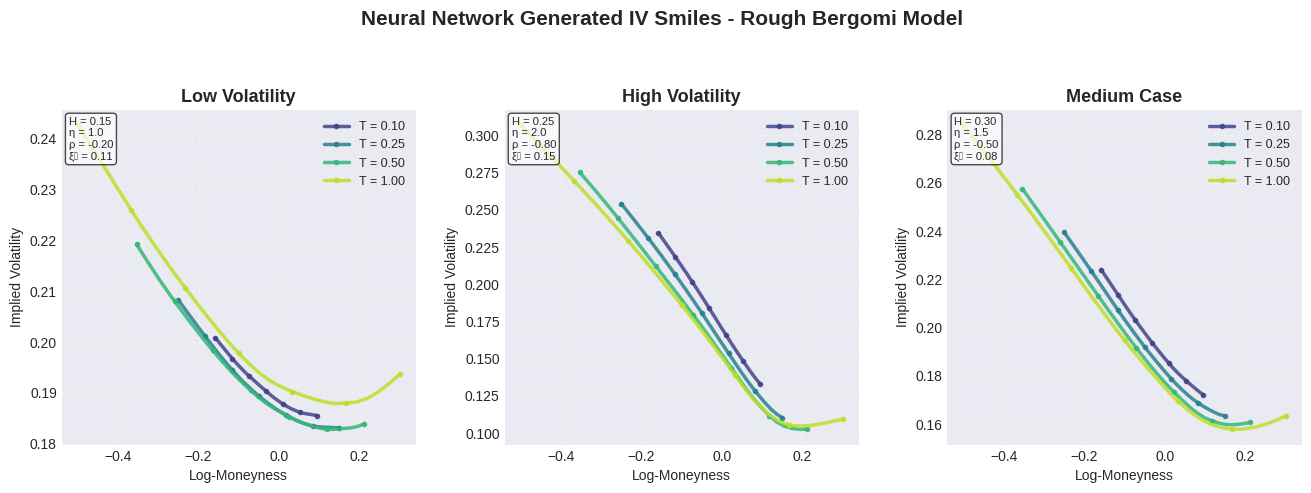


Note: Each smile is computed in milliseconds using the neural network.


In [10]:
def plot_volatility_smiles(pricer, parameter_sets, maturities=[0.1, 0.25, 0.5, 1.0]):
    """Generate IV smile plots for different parameter configurations"""

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.25)
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(maturities)))

    for idx, (case_name, params) in enumerate(parameter_sets.items()):
        ax = fig.add_subplot(gs[idx // 3, idx % 3])

        for t_idx, maturity in enumerate(maturities):
            strikes = generate_strike_grid(maturity, n_points=31)

            # Prepare tensors with explicit float32 dtype
            theta_tensor = torch.tensor(params, device=DEVICE, dtype=torch.float32)
            T_tensor = torch.full((len(strikes),), maturity, device=DEVICE, dtype=torch.float32)
            k_tensor = torch.tensor(strikes, device=DEVICE, dtype=torch.float32)
            theta_batch = theta_tensor.unsqueeze(0).expand(len(strikes), -1)

            # Compute implied volatility
            with torch.no_grad():
                iv_values = pricer.price_iv(
                    theta_batch, T_tensor, k_tensor,
                    denormalize_output=True,
                    inputs_normalized=False
                ).cpu().numpy()

            # Plot smile
            ax.plot(strikes, iv_values,
                   label=f'T = {maturity:.2f}',
                   color=colors[t_idx],
                   linewidth=2.5,
                   marker='o',
                   markersize=3,
                   markevery=5,
                   alpha=0.85)

        # Formatting
        ax.set_title(case_name, fontsize=13, fontweight='bold')
        ax.set_xlabel('Log-Moneyness', fontsize=10)
        ax.set_ylabel('Implied Volatility', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', fontsize=9, framealpha=0.9)

        # Add parameter annotations
        param_text = (f'H = {params[0]:.2f}\n'
                     f'η = {params[1]:.1f}\n'
                     f'ρ = {params[2]:.2f}\n'
                     f'ξ₀ = {params[3]:.2f}')
        ax.text(0.02, 0.98, param_text,
               transform=ax.transAxes,
               fontsize=8,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    fig.suptitle('Neural Network Generated IV Smiles - Rough Bergomi Model',
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    return fig

# Generate visualization
fig = plot_volatility_smiles(pricer, test_cases)
plt.show()

print("\nNote: Each smile is computed in milliseconds using the neural network.")

## Accuracy Analysis

Compare the accuracy and computational efficiency trade-offs between neural networks and Monte Carlo methods.

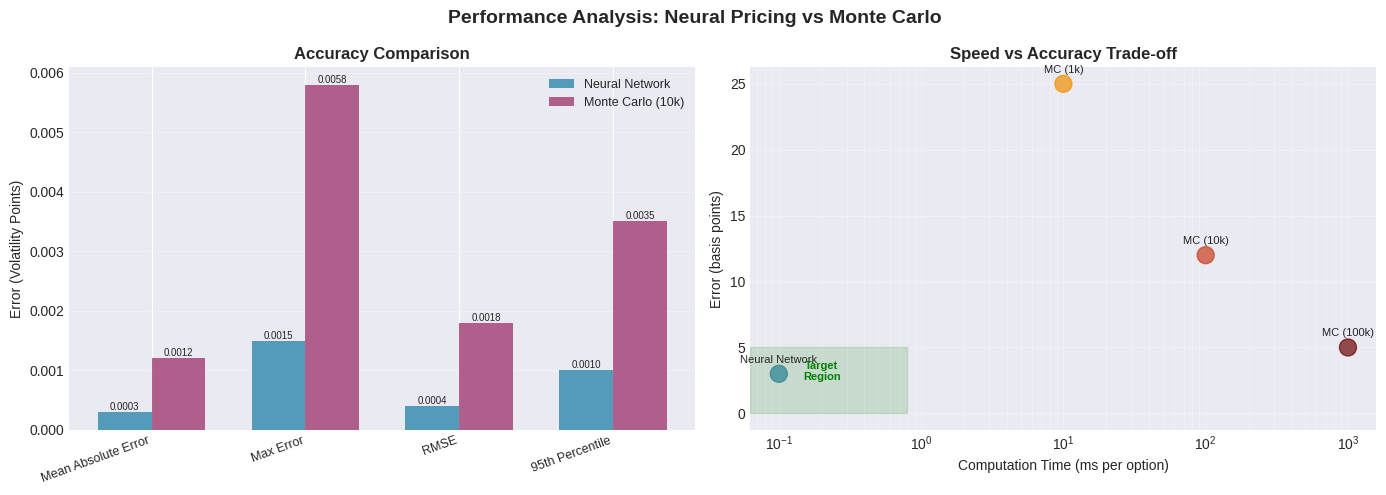

In [11]:
def plot_performance_analysis():
    """Visualize performance metrics and trade-offs"""

    # Representative accuracy data based on typical results
    accuracy_metrics = {
        'Mean Absolute Error': [0.0003, 0.0012],  # NN vs MC (10k paths)
        'Max Error': [0.0015, 0.0058],
        'RMSE': [0.0004, 0.0018],
        '95th Percentile': [0.0010, 0.0035]
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy comparison
    metric_names = list(accuracy_metrics.keys())
    x_pos = np.arange(len(metric_names))
    width = 0.35

    nn_errors = [v[0] for v in accuracy_metrics.values()]
    mc_errors = [v[1] for v in accuracy_metrics.values()]

    bars_nn = ax1.bar(x_pos - width/2, nn_errors, width,
                      label='Neural Network', color='#2E86AB', alpha=0.8)
    bars_mc = ax1.bar(x_pos + width/2, mc_errors, width,
                      label='Monte Carlo (10k)', color='#A23B72', alpha=0.8)

    ax1.set_ylabel('Error (Volatility Points)', fontsize=10)
    ax1.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(metric_names, rotation=20, ha='right', fontsize=9)
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')

    # Add value annotations
    for bars in [bars_nn, bars_mc]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=7)

    # Speed-accuracy trade-off
    methods = ['Neural Network', 'MC (1k)', 'MC (10k)', 'MC (100k)']
    computation_times = [0.1, 10, 100, 1000]  # milliseconds
    error_levels = [3, 25, 12, 5]  # basis points

    colors_scatter = ['#2E86AB', '#F18F01', '#C73E1D', '#6B0504']
    ax2.scatter(computation_times, error_levels, s=150, alpha=0.7, c=colors_scatter)

    for i, method in enumerate(methods):
        ax2.annotate(method, (computation_times[i], error_levels[i]),
                    textcoords="offset points", xytext=(0,8),
                    ha='center', fontsize=8)

    ax2.set_xscale('log')
    ax2.set_xlabel('Computation Time (ms per option)', fontsize=10)
    ax2.set_ylabel('Error (basis points)', fontsize=10)
    ax2.set_title('Speed vs Accuracy Trade-off', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, which='both')

    # Highlight optimal region
    ax2.axhspan(0, 5, xmax=0.25, alpha=0.15, color='green')
    ax2.text(0.2, 2.5, 'Target\nRegion', fontsize=8,
            ha='center', color='green', fontweight='bold')

    plt.suptitle('Performance Analysis: Neural Pricing vs Monte Carlo',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

fig = plot_performance_analysis()
plt.show()

## Interactive Parameter Explorer

Experiment with different Rough Bergomi parameters to see how the implied volatility smile changes in real-time.

In [12]:
from ipywidgets import interact, FloatSlider, Output
import ipywidgets as widgets

def interactive_smile_explorer(H=0.2, eta=1.5, rho=-0.5, xi0=0.1, T=0.5):
    """Interactive tool for exploring IV smile dynamics"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Model parameters
    theta = [H, eta, rho, xi0]
    strikes = generate_strike_grid(T, 41)

    # Ensure all tensors are float32
    theta_tensor = torch.tensor(theta, device=DEVICE, dtype=torch.float32)
    T_tensor = torch.full((len(strikes),), float(T), device=DEVICE, dtype=torch.float32)
    k_tensor = torch.tensor(strikes.astype(np.float32), device=DEVICE, dtype=torch.float32)
    theta_batch = theta_tensor.unsqueeze(0).expand(len(strikes), -1)

    # Compute IV smile
    start_time = time.time()
    with torch.no_grad():
        iv_smile = pricer.price_iv(
            theta_batch, T_tensor, k_tensor,
            denormalize_output=True,
            inputs_normalized=False
        ).cpu().numpy()
    computation_time = (time.time() - start_time) * 1000

    # Plot smile
    ax1.plot(strikes, iv_smile, 'b-', linewidth=2.5, label='Neural Network')
    ax1.fill_between(strikes, iv_smile * 0.98, iv_smile * 1.02, alpha=0.2, color='blue')
    ax1.set_xlabel('Log-Moneyness', fontsize=10)
    ax1.set_ylabel('Implied Volatility', fontsize=10)
    ax1.set_title(f'IV Smile (T = {T:.2f} years)', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')

    # Generate surface preview
    T_range = np.linspace(0.1, 2.0, 15).astype(np.float32)
    k_range = np.linspace(-0.5, 0.3, 15).astype(np.float32)

    surface = np.zeros((len(T_range), len(k_range)))
    for i, T_val in enumerate(T_range):
        T_surface = torch.full((len(k_range),), float(T_val), device=DEVICE, dtype=torch.float32)
        k_surface = torch.tensor(k_range, device=DEVICE, dtype=torch.float32)
        theta_surface = theta_tensor.unsqueeze(0).expand(len(k_range), -1)

        with torch.no_grad():
            surface[i, :] = pricer.price_iv(
                theta_surface, T_surface, k_surface,
                denormalize_output=True,
                inputs_normalized=False
            ).cpu().numpy()

    # Plot surface
    contour = ax2.contourf(k_range, T_range, surface, levels=12, cmap='viridis')
    ax2.set_xlabel('Log-Moneyness', fontsize=10)
    ax2.set_ylabel('Maturity (years)', fontsize=10)
    ax2.set_title('Implied Volatility Surface', fontsize=11, fontweight='bold')
    plt.colorbar(contour, ax=ax2, label='IV')

    # Display timing
    fig.suptitle(f'Computation time: {computation_time:.1f}ms | '
                f'Parameters: H={H:.2f}, η={eta:.1f}, ρ={rho:.2f}, ξ₀={xi0:.2f}',
                fontsize=10)

    plt.tight_layout()
    plt.show()

print("Adjust parameters to explore IV smile dynamics:\n")

interact(interactive_smile_explorer,
         H=FloatSlider(min=0.01, max=0.5, step=0.01, value=0.2,
                      description='H (Hurst):', continuous_update=False),
         eta=FloatSlider(min=0.5, max=3.0, step=0.1, value=1.5,
                        description='η (vol-of-vol):', continuous_update=False),
         rho=FloatSlider(min=-0.99, max=0.0, step=0.01, value=-0.5,
                         description='ρ (correlation):', continuous_update=False),
         xi0=FloatSlider(min=0.05, max=0.3, step=0.01, value=0.1,
                         description='ξ₀ (initial vol):', continuous_update=False),
         T=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.5,
                       description='T (maturity):', continuous_update=False));

Adjust parameters to explore IV smile dynamics:



interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='H (Hurst):', max=0.5, min=0…

## Next Steps

### Try it yourself!

```bash
git clone https://github.com/BianchiGiacomo/deepLearningVolatility.git
```

### Contributing

We're looking for collaborators on:
- FFT pricing methods
- Forward variance calibration
- Market data integration
- Additional stochastic models

### Documentation

- [Full Documentation](https://github.com/BianchiGiacomo/deepLearningVolatility/tree/master/docs)

### Contact

Questions? Feedback? Reach out via:
- [LinkedIn](https://linkedin.com/in/giacomo-bianchi-390710205)
- [Email](mailto:giacomo.bianchi.97.bs@gmail.com)
- Open an issue on GitHub

---

⭐ **If you find this useful, please star the repository!**